# This notebook configures a CFM run for a single site, runs the CFM, and processes/plots the outputs.

### It should run if you put it in the CFM_main directory.

But it should still be considered in beta - please let me know if you have issues!

In [1]:
#!/usr/bin/env python

import numpy as np 
import pandas as pd
import xarray as xr
import glob
import io
import multiprocessing
import sys
import os
import time
import json
import shutil


"""
runCFM_notebook.ipynb
=======
This notebook configures a CFM run and then runs it.
- it goes in CFM_main 

- Forcing data:
    - this example file uses a pickled dataframe with climate data (MERRA-2) for DYE-2 to force the CFM
    - these climate data come from a zarr store with MERRA-2 climate data
    - That zarr contains MERRA-2 climate fields that I have subsetted, getting just the variables
      from MERRA-2 that CFM needs for either Antarctica or Greenland.
    - the zarr store is too large to put on github, but if you want it I will gladly send it to you.
    - the function to run the CFM with that zarr store is included.

- this notebook creates a .json configuration file
- CFM runs with the climate input and config file, results get put
  in the specified directory.
"""

from firn_density_nospin import FirnDensityNoSpin
import RCMpkl_to_spin as RCM

In [2]:
### (optional) Set plot parameters (seaborn, matplotlib)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

In [6]:
### specify latitude and longitude you want

### this is DYE2
lat_int = 66.5 # latitude of interest
lon_int = -46.25 #longitude of interest

### Summit:
# lat_int = 72.5 
# lon_int = -38.75 



In [7]:
# ##########
# ### below function gets climate data to force from a (big!) zarr store
# ### will not work unless you get the zarr from me
# def MERRA2_zarr_to_dataframe(lat_int,lon_int):
#     '''
#     Create a pandas dataframe for a site in Greenland
#     returns:
#     df_daily: a dataframe holding all of the forcing fields needed for CFM run
    
#     input mass fluxes from zarr are in kg/m2/s.
#     mass fluxes in df_daily are in kg/m2/timestep
#     energy fluxes are W/m2
    
#     in MERRA, ?positive? sublimation flux = sublimation, ?negative? = deposition
#     '''
#     def make_dataframe(dsZ,lat_int,lon_int):
#             lat_ll = dsZ.lat.data
#             lon_ll = dsZ.lon.data
#             ii, lat_val = min(enumerate(lat_ll), key=lambda x: abs(x[1]-lat_int))
#             jj, lon_val = min(enumerate(lon_ll), key=lambda x: abs(x[1]-lon_int))

#             df_sub = pd.DataFrame(index=dsZ.time.values)

#             varlist = [jj for jj in dsZ.variables if jj not in ['time','lat','lon']]

#             for vv in varlist:
#                 if vv=='FRLANDICE':
#                     FRLI = dsZ.isel(lat=[ii],lon=[jj])[vv].values.flatten()
#                 else:
#                     df_sub[vv] = dsZ.isel(lat=[ii],lon=[jj])[vv].values.flatten()

#             df_sub['RAIN'] = (df_sub['PRECLS']+df_sub['PRECCU'])*4*3600
#             df_sub['EVAP'] = df_sub['EVAP']*4*3600
#             df_sub['PRECSN'] = df_sub['PRECSN']*4*3600
#             df_sub['SMELT'] = df_sub['SMELT']*4*3600

#             FRLI = dsZ.isel(lat=[ii],lon=[jj]).FRLANDICE.values

#             drn = {'T2M':'T2m','TS':'TSKIN','EVAP':'SUBLIM','HFLUX':'QH','EFLUX':'QL','SWGDN':'SW_d','LWGAB':'LW_d','RAIN':'RAIN','PRECSN':'BDOT','ALBEDO':'ALBEDO','SMELT':'SMELT'}

#             df_sub = df_sub[drn.keys()]
#             df_sub.rename(mapper=drn,axis=1,inplace=True)

#             return ii,jj,lat_val,lon_val,df_sub, FRLI
        
#     decades = [1980,1990,2000,2010,2020]
#     df_dict = {}
#     for decade in decades:
#         file = f"/Users/cdsteve2/RCMdata/M2/zarr/GrIS_4h/M2_GrIS_4h_melt_{decade}.zarr"
#         # file = f"/PATH/TO/ZARR/GrIS_4h/M2_GrIS_4h_melt_{decade}.zarr"
#         with xr.open_dataset(file,engine='zarr') as dsZ:
#             ii,jj,lat_val,lon_val,df_sub, FRLI = make_dataframe(dsZ,lat_int,lon_int)
#             df_dict[decade] = df_sub
            
#     df_out = pd.concat(df_dict.values())

#     df_out['QL'] = -1 * df_out['QL']
#     df_out['QH'] = -1 * df_out['QH']

#     return ii,jj,lat_val,lon_val,df_out,FRLI

In [3]:
### Call the function to create the dataframe, save as a pkl
### (need the zarr)
# ii,jj,lat_val,lon_val,df_daily, FRLI = MERRA2_zarr_to_dataframe(lat_int,lon_int)
# print(ii, jj, lat_val, lon_val)
# pd.to_pickle(df_daily,f'CFM_example_{lat_val}_{lon_val}.pkl')

In [8]:
### load the premade .pkl for the lat/lon pair

lat_val = lat_int
lon_val = lon_int

df_daily = pd.read_pickle(f'CFMinput_example/CFM_example_{lat_val}_{lon_val}.pkl')

This is the key bit to using the CFM this way - all of the forcing data goes into a pandas data frame with a datetime index.

Mass fluxes (ie., precip, sublimation) need to be in units $kg/m^{2}/dt$, where dt is the the time delta of the dataframe. I.e., if your dataframe is daily resolution, the units are $kg/m$^{2}$/day$. In this example, since it is 4-hourly, the mass fluxes are the kg/m2 from that 4 period.

so, with this information, hopefully you can make a working dataframe with your own climate data. Email me if you have questions or issues! maxstev@umd.edu

In [10]:
### The input dataframe
df_daily.head()

,T2m,TSKIN,SUBLIM,QH,QL,SW_d,LW_d,RAIN,BDOT,ALBEDO,SMELT
1980-01-01 00:00:00,254.612274,252.187622,0.016814,35.694057,-3.267121,0.000000,200.776718,0.0,0.001115,NaN,0.0
1980-01-01 04:00:00,254.155701,251.917847,0.010615,31.006149,-2.061395,0.000000,216.736069,0.0,0.005127,NaN,0.0
1980-01-01 08:00:00,255.687790,253.306488,0.001143,26.883553,-0.227627,0.000000,220.662811,0.0,0.009163,NaN,0.0
1980-01-01 12:00:00,253.677551,251.377319,0.006582,38.824802,-1.271402,0.410366,185.453598,0.0,0.000629,0.746733,0.0
1980-01-01 16:00:00,252.690079,249.926086,0.015300,51.825771,-2.967528,0.000363,171.632416,0.0,0.000266,0.741442,0.0


In [17]:
### This function contains all of the CFM configuration options. You can change them, and the configuration gets stored as a .json file.
### The values here are more or less the defaults.

def makejson():
    false = False
    true = True
    c = {
    "InputFileFolder": "CFMinput",
    "InputFileNameTemp": "example_tskin.csv",
    "InputFileNamebdot": "example_smb.csv",
    "InputFileNameIso": "example_isotope.csv",
    "InputFileNamerho": "example_rhos.csv",
    "InputFileNamemelt": "example_melt.csv",
    "resultsFolder": "CFMoutput/test",
    "initfirnFile": "example_firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "MERRA2_CLIM_df_72.5_-38.75.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": true,
    "ReehCorrectedT": false,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": true,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": false,
    "srho_type": "userinput",
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "mean",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": true,
    "grid_output_res": 0.25,
    "isoDiff": false,
    "iso": "NoDiffusion",
    "isoOptions":["18","D","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","meltoutputs"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": "CFMresults.hdf5",
    "spinFileName": "CFMspin.hdf5",
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 5.0,
    "grid2bottom": 10.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": false,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True,
    "keep_firnthickness": true,
    "SEB_TL_thick": 0.05,
    "albedo_factor": 1
    }

    return c

In [19]:
tnow = time.time()
runid=-9999

### The CFM takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
### The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
### containing the vectors that the CFM needs to run.
### the function also returns some other variables that will be used to configure the CFM run.

#######
### Prepare config .json (which is a dictionary called c within this python script) ###
### edit as you wish here (the makejson function above just has defaults, you can change there as well)
### the edited json will be saved and used for the run.
c = makejson()

timeres = '2d' #time resolution for the run, 5 days here (1 day is usually what I run, but slower)
sds = 1980.0 #spin date start
sde = 1995.0 #spin date end
runid = -9999 #arbitrary, but you can use this to keep track of runs

c['physRho'] = 'GSFC2020' # firn densification equation
c['runID'] = runid
c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.

c['SEB'] = True #surface energy balalnce module
c['MELT'] = True # whether to run melt module or not.
c['rain'] = True

c['lat_int'] = float(lat_int)
c['lon_int'] = float(lon_int)
c['lat_val'] = float(lat_val)
c['lon_val'] = float(lon_val)

'''
CFM regrids (merges) deeper nodes to save computation. There are 2 mergings
nodestocombine and multnodestocombine should be adjusted based on the time resolution of the run
e.g. if DFresample is '1d', nodestocombine = 30 will combine 30 layers at an intermediate depth, 
and multnodestocombine = 12 will combine 12 of those layers at a greater depth (which in this case 
will give 3 sections of firn - near the surface very thin layers, representing a day's accumulation,
middle, which is a month's accumulation, and deep, that should be a year's accumulation. 
e.g. if I am doing DFresample = '5d', I would set nodestocombine to 6 to still get layers that are a
month's worth of accumulation. (there is no 'best' way to do this - it is a bit of an art)
'''
c["doublegrid"] = True
c['nodestocombine'] = 6 
c['multnodestocombine'] = 12

### surface density (fixed or variable)
variable_srho = False
if variable_srho:
    c['variable_srho'] = True
    c['srho_type'] = "noise"
else:
    c['rhos0'] = 350.0 #e.g here you could change the surface density
    rhotype=f"rho{c['rhos0']}"
#######

rf_pre = 'CFMoutputs_example'
rf_po = f'/CFMresults_{lat_val}_{lon_val}_{c["physRho"]}_notebook'

c['resultsFolder'] = rf_pre + rf_po #path (within CFM_main that the results will be stored in)

### format the CFM forcing data (including creating the spin up)
### climateTS is a dictionary with the various climate fields needed, in the correct units.
climateTS, StpsPerYr, depth_S1, depth_S2, grid_bottom, SEBfluxes = (
    RCM.makeSpinFiles(df_daily,timeres=c['DFresample'],Tinterp='mean',spin_date_st = sds, 
    spin_date_end = sde, melt=c['MELT'], desired_depth = None, SEB=c['SEB'], rho_bottom=910))

climateTS['SUBLIM'] = -1 * climateTS['SUBLIM'] #ADDED THIS FOR MERRA2 TO GET THE SIGN CORRECT.
climateTS['forcing_data_start'] = sds

c["stpsPerYear"] = float('%.2f' % (StpsPerYr))
c["stpsPerYearSpin"] = float('%.2f' % (StpsPerYr))
c["grid1bottom"] = float('%.1f' %(depth_S1))
c["grid2bottom"] = float('%.1f' %(depth_S2))
c["HbaseSpin"] = float('%.1f' %(3000 - grid_bottom))

c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 

c['keep_firnthickness'] = True
c['grid_outputs'] = True
c['grid_output_res'] = 0.05

configName = 'CFMconfig_{}_{}_{}.json'.format(lat_val,lon_val,c['physRho'])
if os.path.exists(os.path.join(c['resultsFolder'],configName)):
    CFMconfig = os.path.join(c['resultsFolder'],configName)
    shutil.move(CFMconfig, os.getcwd())
else:
    CFMconfig = configName

with open(CFMconfig,'w') as fp:
    fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))

NewSpin = True # rerun the spin up each time if true

### Create CFM instance by passing config file and forcing data, then run the model
firn = FirnDensityNoSpin(CFMconfig, climateTS = climateTS, NewSpin = NewSpin, SEBfluxes = SEBfluxes)
firn.time_evolve()
###
telap = (time.time()-tnow)/60
print('main done, {} minutes'.format(telap))

shutil.move(configName,os.path.join(c['resultsFolder'],configName))

stepsperyear: 182.62536221013315
Spin run started
physics are GSFC2020
Grid length is 59955
AHL: 0.49954330921173096
THL: 252.39556884765625
After doublegrid, grid length is  2205
forcing_filename not in json. Defaulting to CFMforcing.hdf5
Main run starting
physics are GSFC2020
Initial LWC provided by spin-up
updatedStartDate 20.991746796915706
ALBEDO is multipled by 1
modeltime 1676.0 2022.9945205479453
estimated model run time (seconds): 196.39515827322006
updating spin file at 1700.0
updating spin file at 1900.0
updating spin file at 1980.0
Totals (m w.e.)
Melt+Rain:      59.91865599233533
meltvol:        59.918655992335616
rainvol:        0.0
Refreezing:     53.024715777571316
Runoff:         6.584643069013378
LWC (current):  0.0
Refrz + Rnff +LWC:   59.91865599233527

main done, 3.9468832850456237 minutes


'CFMoutputs/CFMresults_66.5_-46.25_GSFC2020/CFMconfig_66.5_-46.25_GSFC2020.json'

In [20]:
# put the results in a dictionary, which is convenient if you do multiple similar runs
fns = ['GSFC2020']
rd = {} #results dictionary
for rt in fns:
    print(rt)
    rd[rt] = {}
    with xr.open_dataset(f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{rt}/CFMresults.hdf5') as fn: # Open the CFM results file
    # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
    # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[rt]['model_time'] = fn['density'][1:,0] # the first column of the density data is the model time step.
        rd[rt]['depth'] = fn['depth'][1:] # Put the depth data into a numpy array
        rd[rt]['density'] = fn['density'][1:,1:] # Put the density data into an array
        rd[rt]['temperature'] = fn['temperature'][1:,1:]
        rd[rt]['DIP'] = fn['DIP'][1:,1:]
        fn.close() # Close the file

GSFC2020


Text(0, 0.5, 'Depth (m)')

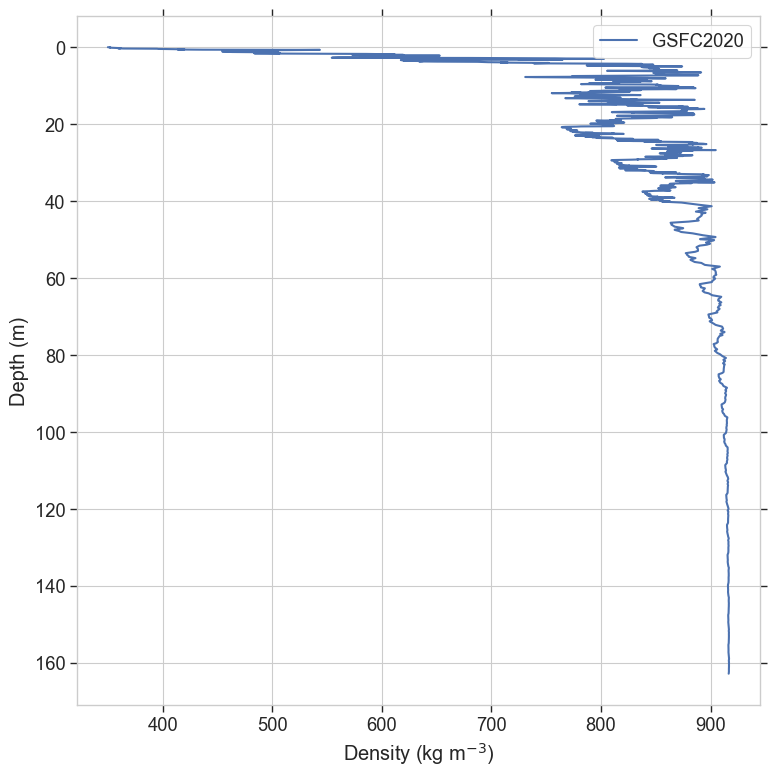

In [21]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['density'][-1,:],rd[rt]['depth'],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')

Text(0, 0.5, 'Firn Air content (m)')

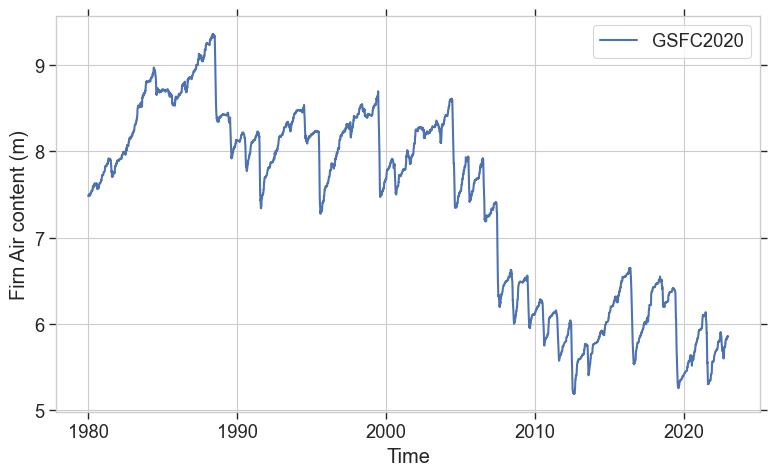

In [22]:
### Plot FAC through time
f1,a1=plt.subplots(figsize=(8,5))
for rt in fns:
    a1.plot(rd[rt]['model_time'][:],rd[rt]['DIP'][:,0],label=rt)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('Firn Air content (m)')

Text(0, 0.5, 'change in Firn Air content (m)')

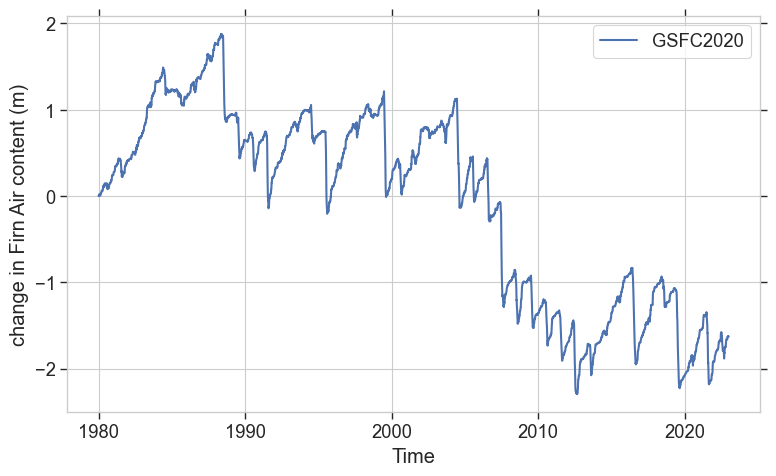

In [23]:
### Plot change in FAC through time
f1,a1=plt.subplots(figsize=(8,5))
for rt in fns:
    a1.plot(rd[rt]['model_time'][:],rd[rt]['DIP'][:,0]-rd[rt]['DIP'][0,0] ,label=rt)
a1.legend()
a1.set_xlabel('Time')
a1.set_ylabel('change in Firn Air content (m)')